<h1>Vgg19 UNet

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

!chmod 600 /content/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip \*.zip
!rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, Convolution2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Add, Lambda, ReLU, LeakyReLU, concatenate
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')
import random
from glob import glob
from IPython.display import display

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Set Parameters
im_width = 256
im_height = 256

# **Load image's path and mask's path**

In [ ]:
train_files = []
mask_files = glob('/content/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_28.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_17.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_26.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_32.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_20.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_3.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_27.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_21.tif', '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_23.tif']
['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_199508

## **Create data frame and split data on train set, validation set and test set**

In [ ]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


## **Data genertator, data augmentation and adjust data**

In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

# Create Model

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output
    s2 = vgg19.get_layer("block2_conv2").output
    s3 = vgg19.get_layer("block3_conv4").output
    s4 = vgg19.get_layer("block4_conv4").output

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model

In [ ]:
vgg19unet = build_vgg19_unet((256,256,3))
vgg19unet.summary()

Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

## Training  Model

In [ ]:
from tensorflow.keras import backend as K
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 0.001
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [ ]:
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
vgg19unet.compile(optimizer = adam,
                  loss = focal_tversky,
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=30
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="Model3_Vgg19Unet_BrainMriSeg.h5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )


In [ ]:
train_generator_args = dict(vertical_flip=True,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
history = vgg19unet.fit(train_gen,
                  epochs = EPOCHS,
                  steps_per_epoch=len(df_train) / BATCH_SIZE,
                  validation_data = val_gen,
                  validation_steps=len(df_val) / BATCH_SIZE,
                  callbacks = [checkpointer, earlystopping, reduce_lr])

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/100
89/88 [==============================] - ETA: -1s - loss: 0.9823 - tversky: 0.0236Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 0.96977, saving model to Model3_Vgg19Unet_BrainMriSeg.h5
88/88 [==============================] - 251s 2s/step - loss: 0.9823 - tversky: 0.0236 - val_loss: 0.9698 - val_tversky: 0.0410 - lr: 0.0010
Epoch 2/100
89/88 [==============================] - ETA: -1s - loss: 0.9520 - tversky: 0.0631
Epoch 2: val_loss improved from 0.96977 to 0.95593, saving model to Model3_Vgg19Unet_BrainMriSeg.h5
88/88 [==============================] - 159s 2s/step - loss: 0.9520 - tversky: 0.0631 - val_loss: 0.9559 - val_tversky: 0.0609 - lr: 0.0010
Epoch 3/100
89/88 [==============================] - ETA: -1s - loss: 0.9384 - tversky: 0.0809
Epoch 3: val_loss improved from 0.95593 to 0.95243, saving model to Model3_Vgg19Unet_Br

In [ ]:
# vgg19unet = load_model("/content/drive/MyDrive/Colab Notebooks/Temp Notebooks/Models/Model3_Vgg19Unet_BrainMriSeg.h5",custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss})

## Model Evaluation

In [ ]:
history.history.keys()

dict_keys(['loss', 'tversky', 'val_loss', 'val_tversky', 'lr'])

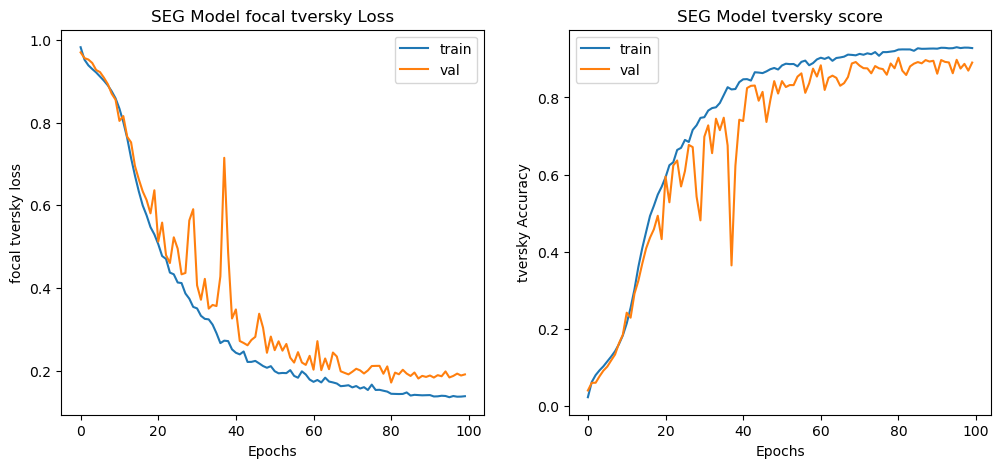

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky']);
plt.plot(history.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)

## Segmantatiın Model Performance

In [ ]:
def prediction(test, model_seg):

    # empty list to store results
    mask, image_id,has_mask = [], [], []

    #itetrating through each image in test data
    for i in test.image_path:



        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)

        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img

        #make prediction of mask
        predict = model_seg.predict(X)

        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})


In [ ]:
# making prediction
df_pred = prediction(X_test, model)
df_pred

,image_path,predicted_mask,has_mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,"[[[[1.1203034e-06], [9.174957e-07], [3.1007772...",1
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,"[[[[2.1512499e-06], [1.2520671e-06], [8.843553...",1
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,"[[[[2.2100455e-06], [1.3285784e-06], [9.865912...",1
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,"[[[[1.6281494e-06], [9.373054e-07], [4.6930438...",1
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,"[[[[1.8706613e-06], [1.0442246e-06], [6.318203...",1
...,...,...,...
98,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,"[[[[2.2032798e-06], [1.2050823e-06], [1.020279...",1
99,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,"[[[[1.237755e-06], [9.2264804e-07], [3.1713114...",1
100,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,"[[[[1.7187025e-06], [1.0246918e-06], [5.33036e...",1
101,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,"[[[[1.7449111e-06], [9.901806e-07], [5.447796e...",1


In [ ]:
# merging original and prediction df
df_pred = X_test.merge(df_pred, on='image_path')
df_pred.head(10)

,patient_id,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_7306_19930512,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1,"[[[[1.1203034e-06], [9.174957e-07], [3.1007772...",1
1,TCGA_DU_6400_19830518,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1,"[[[[2.1512499e-06], [1.2520671e-06], [8.843553...",1
2,TCGA_DU_5849_19950405,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,"[[[[2.2100455e-06], [1.3285784e-06], [9.865912...",1
3,TCGA_FG_5962_20000626,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1,"[[[[1.6281494e-06], [9.373054e-07], [4.6930438...",1
4,TCGA_DU_8165_19970205,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,"[[[[1.8706613e-06], [1.0442246e-06], [6.318203...",1
5,TCGA_DU_7010_19860307,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,"[[[[1.6877248e-06], [1.0124767e-06], [5.172312...",1
6,TCGA_DU_7304_19930325,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,1,"[[[[1.9478982e-07], [4.2037172e-07], [3.441848...",1
7,TCGA_DU_6404_19850629,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,"[[[[1.7697308e-06], [1.0180274e-06], [5.560571...",1
8,TCGA_FG_A4MT_20020212,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,1,"[[[[2.1074109e-06], [1.2000842e-06], [7.772092...",1
9,TCGA_HT_7680_19970202,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,1,"[[[[2.5938893e-06], [1.4566995e-06], [1.227981...",1


In [ ]:
#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')

        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')

        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')

        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')

        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')

        count +=1
    if (count==15):
        break

fig.tight_layout()
